In [2]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
import skimage
from skimage import exposure
from skimage.color import rgb2gray
from scipy.ndimage import convolve, uniform_filter
from skimage.filters import gabor_kernel, unsharp_mask, threshold_otsu, gabor
from skimage.morphology import disk, closing, dilation
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.vis import draw_bboxes
from utils.dataset import sliding_window
from utils.dataset import load_yolo_labels
from utils.bboxes import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram
from utils.dataset import adjust_labels_for_pooling, resize_image_and_bboxes
from models.kernels import AlexNetDescriptor, CannyDescriptor, HogDescriptor

In [3]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [4]:
def export_features(export_path, name, feature_name, feature_list):
    """Save features to npy file

    Args:
        export_path (str): path to save the file
        name (str): file name to save
        feature_name (str): name of the feature. Ex: 'lbp', 'hog', 'gabor'
        feature_list (list/array): list of features
    """
    ## Export features to file
    save_name = f'{name}_{feature_name}.npy'
    save_path = os.path.join(export_path, save_name)
    np.save(save_path, feature_list)
    print(f'Save {feature_name} features to {save_path}')

## Histogram Matching

In [5]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, image_folder, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)
### Export mean histogram to npy file
np.save('mean_hist.npy', mean_histogram)

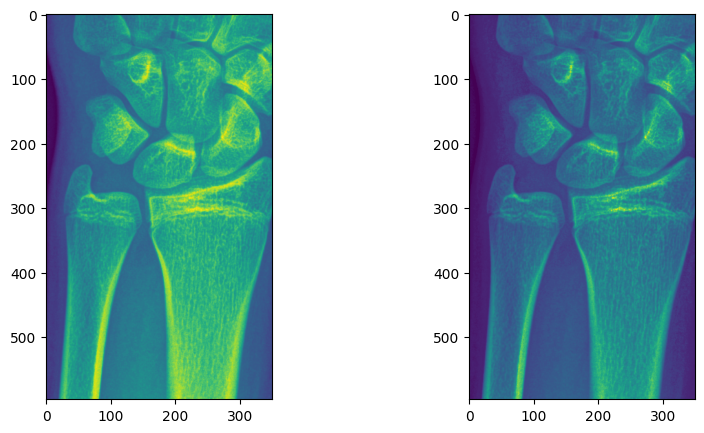

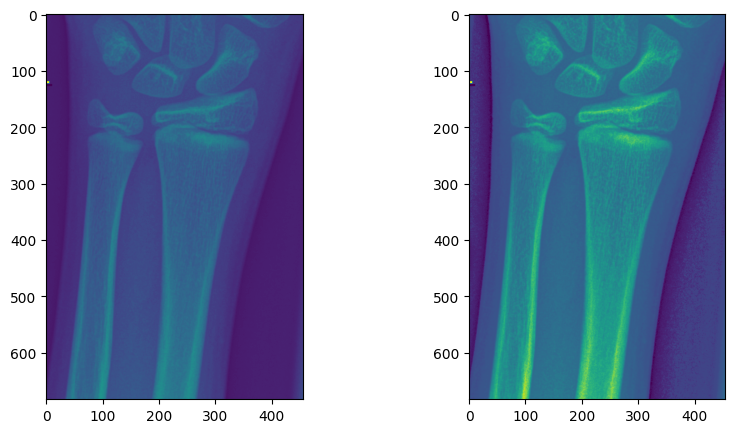

In [6]:
### Visualize the mean histogram
for i, image_file in enumerate(image_files):
    if i > 1:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [7]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Convert boolean mask to 8-bit integer
    binary_mask = binary_mask.astype(np.uint8) * 255  # Convert boolean to uint8
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)

    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour based on area
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour
    
    # Create a mask for the largest contour
    if largest_contour is not None:
        mask = np.zeros_like(binary_mask)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
        # Apply the mask to the original image
        final_image = cv2.bitwise_and(image, image, mask=mask)
    
    return final_image


In [8]:
def process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, pool_size=(4,4), resize=None):
    """
    Processes an image by preprocessing and loading corresponding labels, then applies pooling.

    Args:
    image_path (str): Path to the image file.
    mean_histogram (bool): Flag for histogram processing.
    intensity_crop (tuple): Intensity cropping parameters.
    outputbitdepth (int): Bit depth for image output.
    unsharp (bool): Flag for unsharp mask processing.
    pool_size (tuple): Size of the pooling window.

    Returns:
    tuple: A tuple containing the processed image and associated labels.
    """
    labels = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    ### Parse label from yolo format
    image_name = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    if os.path.exists(label_path):
        labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Preprocess image
    img = preprocess(img, mean_histogram=mean_histogram, intensity_crop=intensity_crop, outputbitdepth=outputbitdepth, unsharp=unsharp)
    
    # Apply pooling to downscale the image for computation efficiency and remain important characteristics features
    if pool_size is not None:
        img = skimage.measure.block_reduce(img, pool_size, np.max)
        # Adjust labels for pooling
        labels = adjust_labels_for_pooling(labels, img.shape, pool_size)
    if resize:
        img, labels = resize_image_and_bboxes(img, labels, resize)
        
    return img, labels

## Extract Features

In [9]:
import skimage.measure

## Extract features from an image using a given descriptor with sliding window
def feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, descriptor, stepSize=128, windowSize=256, pool_size=(4, 4), heatmap=None):
    """
    Extract features from an image using a given descriptor.

    Args:
    - image_path (str): Path to the image file.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.
    - unsharp (bool): Flag for unsharp mask processing.
    - descriptor (object): The descriptor object to use for feature extraction.
    - show_grid (bool): Flag to show the grid of windows.

    Returns:
    - features (list): List of features extracted from the image.
    - labels_list (list): List of labels for each feature.
    """
    features = []
    labels_list = []
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, pool_size)
    ## scale heatmap to the same size as the image
    if heatmap is not None:
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # feature_image = image     

    for i, (x, y, window_f) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_f.shape[0] != windowSize or window_f.shape[1] != windowSize:
            continue
        # ## Image histogram 
        window_f = skimage.measure.block_reduce(window_f, (2, 2), np.max)
        # Calculate the percentage of zero values
        zero_percentage = np.mean(window_f == 0) * 100
        if zero_percentage > 50:
            continue
        
        feature_image = descriptor(window_f)     
        feature = feature_image.ravel()
        if heatmap is not None:
            feature = np.append(feature, heatmap[y:y+windowSize, x:x+windowSize].ravel())
        
        iou_score = 0
        class_id = 0
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.5:
                class_id = 1
            else:
                class_id = 0
        
        features.append(feature)
        labels_list.append(class_id)
            
    return features, labels_list

In [10]:
# Parameters for feature extraction
windowSize = 64
stepSize = 32
pool_size = (4, 4)
outputbitdepth = 8 # Set output bit depth
unsharp = True # Sharpen image
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

### HOG

In [ ]:
### Extract HOG features and export to npy file
hogdes = HogDescriptor()

modes = ["train", "test"]
class_names = ["fracture", "normal"]

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                hogdes,
                stepSize=stepSize,
                windowSize=windowSize,
                pool_size=pool_size,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="hog",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_hog",
            feature_list=labels_list,
        )

### Hog - Canny Features

In [ ]:
# Extract Hog features from Canny edges and export to npy file
modes = ["train", "test"]
class_names = ["fracture", "normal"]

canny_descriptor = CannyDescriptor()

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                canny_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="hog_canny",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_hog_canny",
            feature_list=labels_list,
        )

### AlexNet Features

In [ ]:
# Extract Gabor features from AlexNet's first layer and export to npy file
modes = ["train", "test"]
class_names = ["fracture", "normal"]

alexnet_descriptor = AlexNetDescriptor()

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                alexnet_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="alex",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_alex",
            feature_list=labels_list,
        )

In [225]:
import math 
for i in range(100):
    if labels_list[i] == 1:
        print(labels_list[i])
        f_size = int(math.sqrt(len(features_list[i])))
        plt.imshow(features_list[i].reshape(f_size,f_size), cmap='gray')
        plt.show()

## Machine Learning Model

### Exploit crowded regions - Results are not good

### Load data

In [11]:
feature_list = ['hog', 'alex', 'hog_canny']

train_features_list = []
train_labels = None
test_features_list = []
test_labels = None

for feature_name in feature_list:
    # Load the dictionary from the .npz file
    train_fracture = np.load(os.path.join(root_path, f'train_fracture_{feature_name}.npy'), allow_pickle=True)
    train_normal = np.load(os.path.join(root_path, f'train_normal_{feature_name}.npy'), allow_pickle=True)
    train_fracture_labels = np.load(os.path.join(root_path, f'train_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    train_normal_labels = np.load(os.path.join(root_path, f'train_normal_labels_{feature_name}.npy'), allow_pickle=True)

    test_fracture = np.load(os.path.join(root_path, f'test_fracture_{feature_name}.npy'), allow_pickle=True)
    test_normal = np.load(os.path.join(root_path, f'test_normal_{feature_name}.npy'), allow_pickle=True)
    test_fracture_labels = np.load(os.path.join(root_path, f'test_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    test_normal_labels = np.load(os.path.join(root_path, f'test_normal_labels_{feature_name}.npy'), allow_pickle=True)

    train_features = np.concatenate([train_fracture, train_normal])
    train_labels= np.concatenate([train_fracture_labels, train_normal_labels])
    train_indices = np.where(train_labels!= -1)[0]
    train_features = train_features[train_indices]
    train_labels= train_labels[train_indices]

    test_features= np.concatenate([test_fracture, test_normal])
    test_labels = np.concatenate([test_fracture_labels, test_normal_labels])
    test_indices = np.where(test_labels!= -1)[0]
    test_features = test_features[test_indices]
    test_labels = test_labels[test_indices]
    
    # Append to the list
    train_features_list.append(train_features)
    test_features_list.append(test_features)

# Concatenate the features
train_features = np.concatenate(train_features_list, axis=1)
test_features = np.concatenate(test_features_list, axis=1)

Hog Feature: 576

Gabor Feature: 49

HogCanny Feature: 324



### Undersampling

In [12]:
import random
random.shuffle(list(range(len(train_features))))

In [13]:
# Split the dataset into majority and minority classes
X_majority = train_features[train_labels == 0]
y_majority = train_labels[train_labels == 0]
X_minority = train_features[train_labels == 1]
y_minority = train_labels[train_labels == 1]

# Downsample the majority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority,
                                                        y_majority,
                                                        replace=False,
                                                        n_samples=len(y_minority),
                                                        random_state=42)

# Combine the downsampled majority class with the minority class
X_balanced = np.vstack((X_majority_downsampled, X_minority))
y_balanced = np.hstack((y_majority_downsampled, y_minority))

In [14]:
np.unique(y_balanced, return_counts=True)

(array([0, 1]), array([1835, 1835]))

### Train Test Split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [17]:
np.unique(train_labels, return_counts=True), np.unique(test_labels, return_counts=True)

((array([0, 1]), array([5979, 1835])), (array([0, 1]), array([1996,  453])))

### Scaling

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_features = scaler.transform(test_features)

### Feature Selection

In [19]:
import mrmr
import pandas as pd

X_train_pd = pd.DataFrame(X_train)
y_train_pd = pd.Series(y_train)
test_features_pd = pd.DataFrame(test_features)

from mrmr import mrmr_classif
### Feature Selection - 600 give the best result
selected_features = mrmr_classif(X=X_train_pd, y=y_train_pd, K=600)
print(selected_features)


100%|██████████| 600/600 [01:17<00:00,  7.72it/s]

[80, 661, 606, 558, 71, 431, 494, 141, 25, 577, 64, 353, 134, 238, 173, 72, 302, 143, 31, 318, 23, 16, 365, 128, 73, 545, 598, 21, 79, 446, 604, 95, 125, 24, 398, 86, 109, 701, 430, 366, 22, 305, 583, 20, 317, 69, 462, 136, 70, 98, 497, 487, 333, 135, 584, 137, 237, 254, 68, 124, 773, 239, 93, 88, 590, 439, 74, 591, 526, 172, 138, 597, 133, 50, 61, 87, 45, 525, 859, 67, 89, 513, 611, 26, 7, 674, 108, 478, 301, 85, 596, 746, 5, 285, 114, 618, 636, 503, 269, 6, 424, 397, 605, 75, 703, 399, 107, 665, 477, 90, 841, 104, 19, 809, 46, 502, 683, 414, 465, 139, 205, 290, 440, 429, 332, 561, 84, 638, 420, 162, 501, 670, 423, 663, 253, 59, 140, 488, 589, 510, 132, 9, 928, 656, 634, 416, 559, 76, 242, 56, 284, 551, 576, 27, 60, 169, 221, 177, 264, 495, 719, 206, 481, 268, 549, 612, 274, 504, 102, 667, 267, 126, 171, 210, 940, 91, 48, 150, 99, 92, 838, 17, 4, 174, 594, 469, 461, 54, 676, 917, 121, 208, 322, 647, 550, 601, 216, 753, 782, 219, 178, 384, 258, 44, 329, 737, 123, 567, 699, 506, 105, 61

In [20]:
X_val_pd = pd.DataFrame(X_val)

X_train = X_train_pd[selected_features].values
X_val = X_val_pd[selected_features].values
test_features = test_features_pd[selected_features].values

In [318]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

### Training

In [494]:
import lightgbm as lgb

In [30]:
# model = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=150)
model = SVC(C=100, kernel='rbf', gamma='auto', probability=True, degree=7, class_weight='balanced')
model.fit(X_train, y_train)


SVC(C=100, class_weight='balanced', degree=7, gamma='auto', probability=True)

In [31]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       367
           1       0.80      0.78      0.79       367

    accuracy                           0.79       734
   macro avg       0.79      0.79      0.79       734
weighted avg       0.79      0.79      0.79       734

[[293  74]
 [ 79 288]]
f1-score: 0.791543460465427


### Hard Mining

In [23]:
def identify_hard_negatives(X_test, y_test, classifier):
    predictions = classifier.predict(X_test)
    misclassified_indices = np.where(predictions != y_test)[0]
    hard_negatives = [X_test[i] for i in misclassified_indices]
    hard_negative_labels = [y_test[i] for i in misclassified_indices]
    return np.array(hard_negatives), np.array(hard_negative_labels)

def hard_negative_mining(X_train, y_train, X_test, y_test, classifier, iterations=5):
    for _ in range(iterations):
        # Identify hard negatives
        hard_negatives, hard_negative_labels = identify_hard_negatives(X_test, y_test, classifier)
        
        # Update training set
        X_train = np.concatenate((X_train, hard_negatives), axis=0)
        y_train = np.concatenate((y_train, hard_negative_labels), axis=0)

        # Retrain classifier
        classifier.fit(X_train, y_train)

        # Optional: Evaluate classifier on the test set after each iteration
        y_pred = classifier.predict(X_test)
        print(f"Iteration {_ + 1}")
        print(classification_report(y_test, y_pred))

    return classifier

In [32]:
model = hard_negative_mining(X_train, y_train, X_val, y_val, model, iterations=2)

Iteration 1
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.98      0.98      0.98       367

    accuracy                           0.98       734
   macro avg       0.98      0.98      0.98       734
weighted avg       0.98      0.98      0.98       734

Iteration 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       367
           1       1.00      1.00      1.00       367

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



## Testing

In [33]:
y_true = test_labels
y_pred = model.predict(test_features)

# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1996
           1       0.47      0.76      0.58       453

    accuracy                           0.80      2449
   macro avg       0.70      0.78      0.72      2449
weighted avg       0.85      0.80      0.81      2449

[[1602  394]
 [ 107  346]]
f1-score: 0.8121103836092103


## Export the model

In [28]:
model_path = 'models/weights/fast_region_proposal_svm.pkl'
scaler_path = 'models/weights/scaler_svm.pkl'

joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)

['models/weights/scaler_svm.pkl']

## Load the model

In [160]:
model = joblib.load(model_path)

In [161]:
scaler = joblib.load('models/weights/scaler_svm.pkl')
